<a href="https://colab.research.google.com/github/haleema1011/AI_Flood_Warning_Nothern_Pakistan/blob/main/flood_prediction_through_SVR%2C_ANN%2C_Xgboost_using_Lagged_features_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**importing important libararies**

In [ ]:
# Re-import the data and process as requested
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np


**uploading data file**

In [ ]:
#load the data
file_path = '/content/drive/MyDrive/kabul_river_met_discharge_data.csv'
data = pd.read_csv(file_path)

**viewing the data**

In [ ]:
data.head(3)

,Date,YEAR,DOY,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,discharge m3/s
0,2005-01-01,2005.0,1.0,-0.576,-6.148,3.240,86.145,2.161,728.1
1,2005-01-02,2005.0,2.0,-0.795,-6.936,2.980,81.400,1.530,792.0
2,2005-01-03,2005.0,3.0,2.891,-8.300,2.612,68.630,0.015,514.3


**setting the date column as index columnn**

In [ ]:
# Parse the date and set it as the index for time series analysis
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

**creating lag features of discharge column **

In [ ]:
# Function to create lag features for time-series forecasting
def create_lag_features(data, target_col, lags=5):
    """Creates lag features for the target column."""
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)
    return df.dropna()

In [ ]:
# Add lag features for discharge (target variable)
lagged_data = create_lag_features(data, 'discharge m3/s', lags=5)

In [ ]:
print(lagged_data)

              YEAR    DOY  T2M_MAX  T2M_MIN   QV2M    RH2M  PRECTOTCORR  \
Date                                                                      
2005-01-06  2005.0    6.0    3.651   -8.947  2.235  61.513        0.000   
2005-01-07  2005.0    7.0    4.545   -7.736  2.558  63.739        0.174   
2005-01-08  2005.0    8.0    3.557   -9.152  2.722  71.182        0.000   
2005-01-09  2005.0    9.0    2.989  -11.851  1.886  63.219        0.000   
2005-01-10  2005.0   10.0    1.410  -12.589  1.409  53.064        0.000   
...            ...    ...      ...      ...    ...     ...          ...   
2020-12-27  2020.0  362.0   -3.808  -12.403  2.210  78.062        0.346   
2020-12-28  2020.0  363.0   -1.672  -12.619  2.046  73.555        0.017   
2020-12-29  2020.0  364.0    1.629  -13.475  1.660  57.732        0.000   
2020-12-30  2020.0  365.0    3.207  -11.469  1.531  46.392        0.028   
2020-12-31  2020.0  366.0    3.119  -11.101  1.567  46.425        0.000   

            discharge m3

In [ ]:
# Select predictors and target after lag feature creation
features_lagged = lagged_data.drop(columns=['discharge m3/s'])
target_lagged = lagged_data['discharge m3/s']

In [ ]:
target_lagged

,discharge m3/s
Date,
2005-01-06,387.7
2005-01-07,379.8
2005-01-08,379.8
2005-01-09,383.3
2005-01-10,354.4
...,...
2020-12-27,223.2
2020-12-28,249.5
2020-12-29,255.6


**scaling the data**

In [ ]:
# Apply RobustScaler to handle outliers
scaler_features_robust = RobustScaler()
scaler_target_robust = RobustScaler()

features_scaled_robust = scaler_features_robust.fit_transform(features_lagged)
target_scaled_robust = scaler_target_robust.fit_transform(target_lagged.values.reshape(-1, 1))

**dividing the data into train and test sets**

In [ ]:
# Split the robust-scaled data
X_train, X_test, y_train, y_test = train_test_split(features_scaled_robust, target_scaled_robust, test_size=0.2, random_state=42, shuffle = False)

In [ ]:
# prompt: shapes of train test sets

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4671, 12)
Shape of X_test: (1168, 12)
Shape of y_train: (4671, 1)
Shape of y_test: (1168, 1)


In [ ]:
# prompt: from which date test set is starting and what is the highest value in ytest on which data

# Assuming the code you provided is already executed and the variables X_test and y_test are defined.

# Find the start date of the test set
test_start_date = lagged_data.index[len(X_train)]
print(f"Test set starts from: {test_start_date}")

# Find the highest value in y_test and its corresponding date
highest_ytest_value = scaler_target_robust.inverse_transform(y_test.max().reshape(1, -1))[0,0] # Inverse transform to get original scale
highest_ytest_index = np.argmax(y_test)
date_of_highest = lagged_data.index[len(X_train) + highest_ytest_index]

print(f"Highest value in y_test: {highest_ytest_value} on {date_of_highest}")

Test set starts from: 2017-10-21 00:00:00
Highest value in y_test: 4145.0 on 2020-09-02 00:00:00


In [ ]:
# Fine-tuning SVR using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],   # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf']         # RBF kernel for non-linear data
}

# Grid search to find the best hyperparameters
grid_search = GridSearchCV(SVR(), param_grid, scoring='r2', cv=5, verbose=1)
grid_search.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             scoring='r2', verbose=1)

In [ ]:
# Retrieve the best parameters from GridSearchCV
best_params = grid_search.best_params_
print(best_params)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


**Evaluating the performance of model**

In [ ]:
# Evaluate the model with multiple metrics
y_pred_robust = grid_search.best_estimator_.predict(X_test)

In [ ]:
y_pred_robust

array([-0.3555681 , -0.3553815 , -0.36053068, ..., -0.26354035,
       -0.29185194, -0.28656292])

**inverse transform the values**

In [ ]:
# Inverse transform predicted and actual values
y_pred_original = scaler_target_robust.inverse_transform(y_pred_robust.reshape(-1, 1))
y_test_original = scaler_target_robust.inverse_transform(y_test)

# Evaluate performance metrics on the original scale
mse_original = mean_squared_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mse_original)
mae_original = mean_absolute_error(y_test_original, y_pred_original)
r2_original = r2_score(y_test_original, y_pred_original)

# Custom Metric: Natche (Nash-Sutcliffe Efficiency)
natche_original = 1 - (np.sum((y_test_original - y_pred_original) ** 2) /
                       np.sum((y_test_original - np.mean(y_test_original)) ** 2))

# Display results
mse_original, rmse_original, mae_original, r2_original


(26939.2556530556, 164.1318240106275, 71.3221661735526, 0.9483705953804943)

MSE: 26939.26
RMSE: 164.13
MAE: 71.32
R-squared: 0.95
Nash-Sutcliffe Efficiency (NSE): 0.95


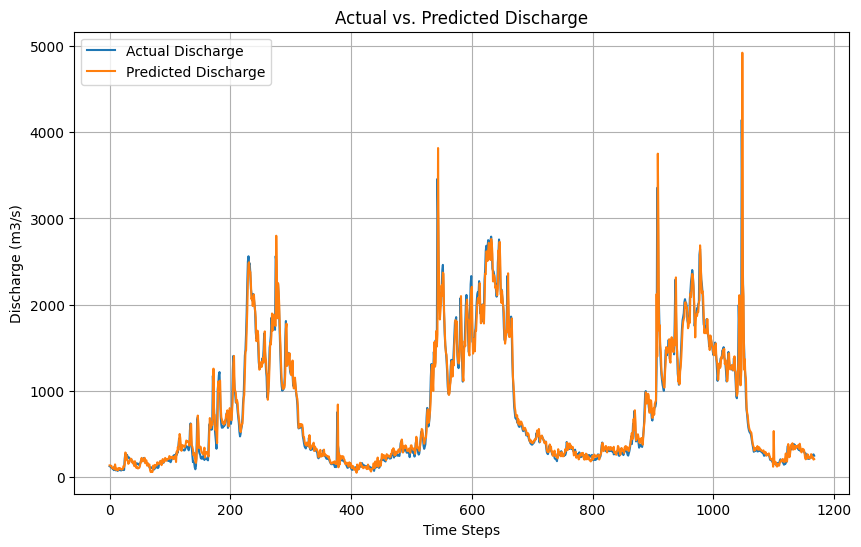

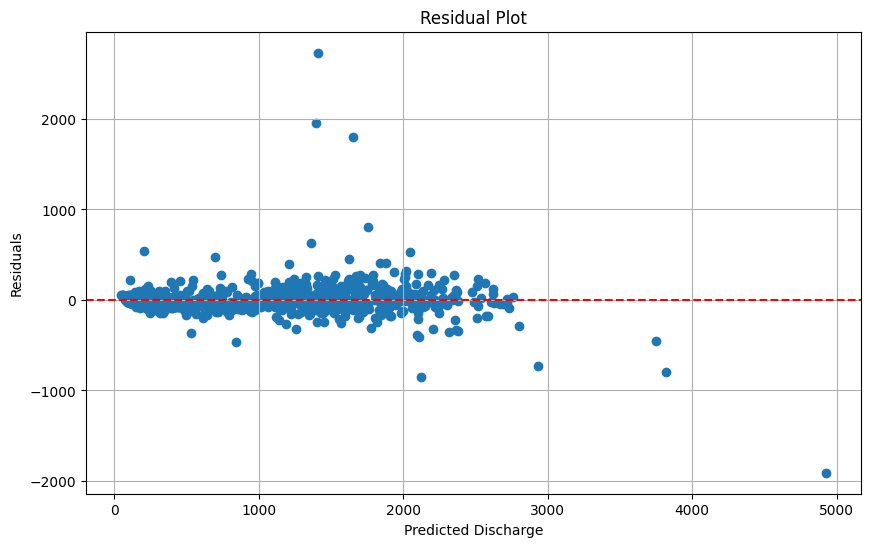

In [ ]:
# prompt: show results to visulize

import matplotlib.pyplot as plt

# ... (Your existing code) ...

# Display results
print(f"MSE: {mse_original:.2f}")
print(f"RMSE: {rmse_original:.2f}")
print(f"MAE: {mae_original:.2f}")
print(f"R-squared: {r2_original:.2f}")
print(f"Nash-Sutcliffe Efficiency (NSE): {natche_original:.2f}")

# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Discharge')
plt.plot(y_pred_original, label='Predicted Discharge')
plt.xlabel('Time Steps')
plt.ylabel('Discharge (m3/s)')
plt.title('Actual vs. Predicted Discharge')
plt.legend()
plt.grid(True)
plt.show()


# Visualize residuals
residuals = y_test_original - y_pred_original
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_original, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Discharge')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [ ]:
# prompt: display the actual and predicted

# Create a DataFrame for better visualization
results_df = pd.DataFrame({'Actual': y_test_original.flatten(), 'Predicted': y_pred_original.flatten()})
results_df

,Actual,Predicted
0,122.60,132.108898
1,118.60,132.307152
2,127.10,126.836153
3,105.20,125.912169
4,98.15,100.871963
...,...,...
1163,223.20,248.373534
1164,249.50,215.736787
1165,255.60,229.888373
1166,260.50,199.807315


In [ ]:
# prompt: what the the higgest discharge value in test data ..and what do mode predict for it

# Find the highest discharge value in the test data
highest_discharge = np.max(y_test_original)
print(f"Highest discharge value in test data: {highest_discharge}")

# Find the corresponding predicted value
index_of_highest = np.argmax(y_test_original)
predicted_for_highest = y_pred_original[index_of_highest]
print(f"Model's prediction for the highest discharge: {predicted_for_highest}")

Highest discharge value in test data: 4145.0
Model's prediction for the highest discharge: [1412.35173403]


In [ ]:
# prompt: generate a excel file of predicted and actual so i can download it

# Create a DataFrame for better visualization
results_df = pd.DataFrame({'Actual': y_test_original.flatten(), 'Predicted': y_pred_original.flatten()})

# Create an excel file of predicted and actual values
results_df.to_excel('predicted_vs_actual.xlsx', index=False)

# Download the excel file
from google.colab import files
files.download('predicted_vs_actual.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**XG BOOST**

In [ ]:
!pip uninstall scikit-learn -y
!pip uninstall xgboost -y

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3


In [ ]:
!pip install scikit-learn==1.0.2

  Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.


In [ ]:
# Importing the XGBoost Regressor
from xgboost import XGBRegressor

# Fine-tuning XGBoost using GridSearchCV
param_grid_xgb = {
    'n_estimators': [50, 100, 200],      # Number of boosting rounds
    'max_depth': [3, 6, 10],             # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],   # Step size shrinkage used in update to prevent overfitting
    'subsample': [0.8, 1.0],             # Subsample ratio of the training instance
    'colsample_bytree': [0.8, 1.0]       # Subsample ratio of columns when constructing each tree
}

# Grid search to find the best hyperparameters for XGBoost
grid_search_xgb = GridSearchCV(XGBRegressor(objective='reg:squarederror'), param_grid_xgb, scoring='r2', cv=5, verbose=1)
grid_search_xgb.fit(X_train, y_train.ravel())

# Retrieve the best parameters from GridSearchCV
best_params_xgb = grid_search_xgb.best_params_
print(best_params_xgb)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# Importing the XGBoost Regressor
from xgboost import XGBRegressor

# Fine-tuning XGBoost using GridSearchCV
param_grid_xgb = {
    'n_estimators': [50, 100, 200],      # Number of boosting rounds
    'max_depth': [3, 6, 10],             # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],   # Step size shrinkage used in update to prevent overfitting
    'subsample': [0.8, 1.0],             # Subsample ratio of the training instance
    'colsample_bytree': [0.8, 1.0]       # Subsample ratio of columns when constructing each tree
}

# Grid search to find the best hyperparameters for XGBoost
grid_search_xgb = GridSearchCV(XGBRegressor(objective='reg:squarederror'), param_grid_xgb, scoring='r2', cv=5, verbose=1)
grid_search_xgb.fit(X_train, y_train.ravel())

# Retrieve the best parameters from GridSearchCV
best_params_xgb = grid_search_xgb.best_params_
print(best_params_xgb)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [ ]:
# Evaluate the XGBoost model with multiple metrics
y_pred_robust_xgb = grid_search_xgb.best_estimator_.predict(X_test)

# Inverse transform predicted and actual values
y_pred_original_xgb = scaler_target_robust.inverse_transform(y_pred_robust_xgb.reshape(-1, 1))
y_test_original_xgb = scaler_target_robust.inverse_transform(y_test)

# Evaluate performance metrics on the original scale for XGBoost
mse_original_xgb = mean_squared_error(y_test_original_xgb, y_pred_original_xgb)
rmse_original_xgb = np.sqrt(mse_original_xgb)
mae_original_xgb = mean_absolute_error(y_test_original_xgb, y_pred_original_xgb)
r2_original_xgb = r2_score(y_test_original_xgb, y_pred_original_xgb)

# Custom Metric: Natche (Nash-Sutcliffe Efficiency) for XGBoost
natche_original_xgb = 1 - (np.sum((y_test_original_xgb - y_pred_original_xgb) ** 2) /
                           np.sum((y_test_original_xgb - np.mean(y_test_original_xgb)) ** 2))

# Display results for XGBoost
mse_original_xgb, rmse_original_xgb, mae_original_xgb, r2_original_xgb


(33953.06408789773, 184.26357233022952, 76.61291313223643, 0.9349285478989376)

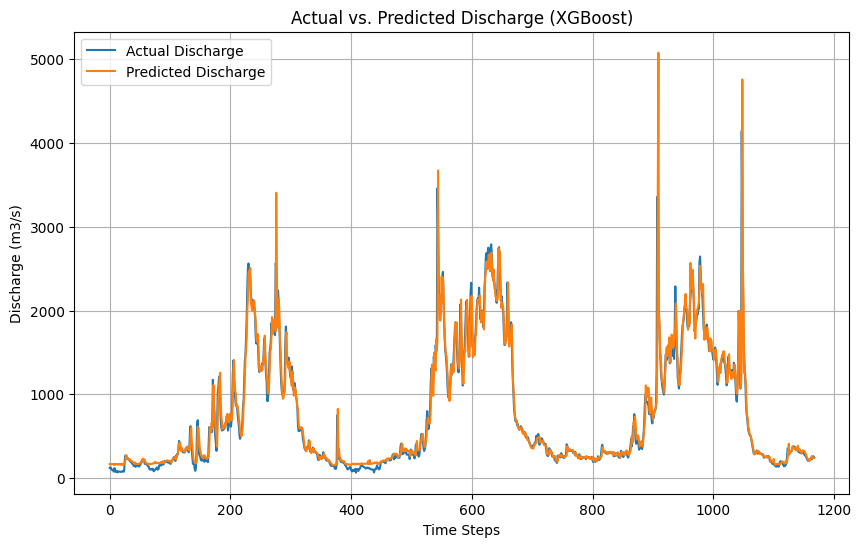

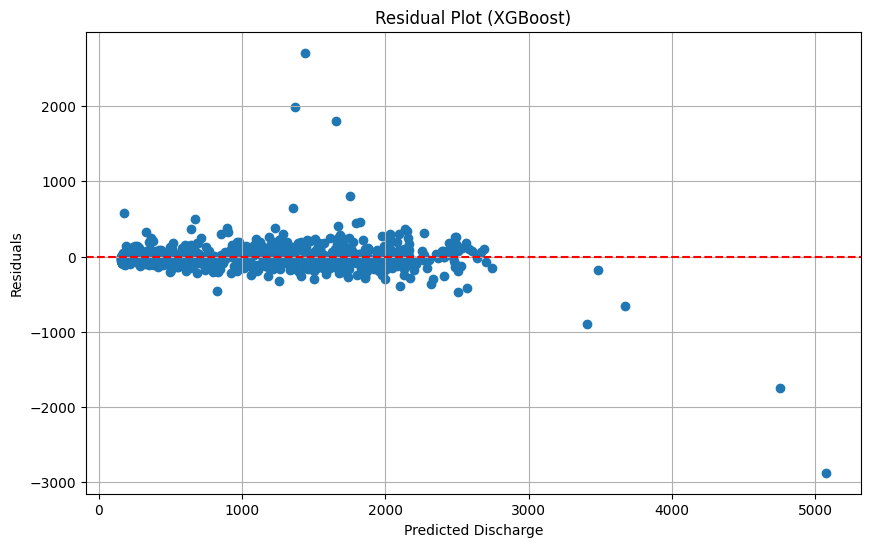

In [ ]:
# prompt: create a  actual vs predicted and residual plot of xgboost

# Visualize actual vs. predicted values for XGBoost
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_xgb, label='Actual Discharge')
plt.plot(y_pred_original_xgb, label='Predicted Discharge')
plt.xlabel('Time Steps')
plt.ylabel('Discharge (m3/s)')
plt.title('Actual vs. Predicted Discharge (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize residuals for XGBoost
residuals_xgb = y_test_original_xgb - y_pred_original_xgb
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_original_xgb, residuals_xgb)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Discharge')
plt.ylabel('Residuals')
plt.title('Residual Plot (XGBoost)')
plt.grid(True)
plt.show()

ANN(MLP)Regressor

In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
!pip install scikit-learn==1.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.2.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.0 which is incompatible.


In [ ]:
!pip install scikit-learn==0.24.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 39.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Importing necessary modules for ANN
from sklearn.neural_network import MLPRegressor

# Fine-tuning ANN using GridSearchCV
param_grid_ann = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Number of neurons in hidden layers
    'activation': ['relu', 'tanh'],                  # Activation functions
    'solver': ['adam', 'lbfgs'],                      # Solver for weight optimization
    'learning_rate': ['constant', 'adaptive'],        # Learning rate schedule
    'max_iter': [200, 500]                            # Maximum number of iterations
}

# Grid search to find the best hyperparameters for ANN
grid_search_ann = GridSearchCV(MLPRegressor(random_state=42), param_grid_ann, scoring='r2', cv=5, verbose=1)
grid_search_ann.fit(X_train, y_train.ravel())

# Retrieve the best parameters from GridSearchCV
best_params_ann = grid_search_ann.best_params_
print(best_params_ann)

# Evaluate the ANN model with multiple metrics
y_pred_robust_ann = grid_search_ann.best_estimator_.predict(X_test)

# Inverse transform predicted and actual values
y_pred_original_ann = scaler_target_robust.inverse_transform(y_pred_robust_ann.reshape(-1, 1))
y_test_original_ann = scaler_target_robust.inverse_transform(y_test)

# Evaluate performance metrics on the original scale for ANN
mse_original_ann = mean_squared_error(y_test_original_ann, y_pred_original_ann)
rmse_original_ann = np.sqrt(mse_original_ann)
mae_original_ann = mean_absolute_error(y_test_original_ann, y_pred_original_ann)
r2_original_ann = r2_score(y_test_original_ann, y_pred_original_ann)

# Custom Metric: Natche (Nash-Sutcliffe Efficiency) for ANN
natche_original_ann = 1 - (np.sum((y_test_original_ann - y_pred_original_ann) ** 2) /
                           np.sum((y_test_original_ann - np.mean(y_test_original_ann)) ** 2))

# Display results for ANN
mse_original_ann, rmse_original_ann, mae_original_ann, r2_original_ann


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

{'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}


(25781.656177842025, 160.566672064417, 87.28310800362064, 0.9505891485752389)

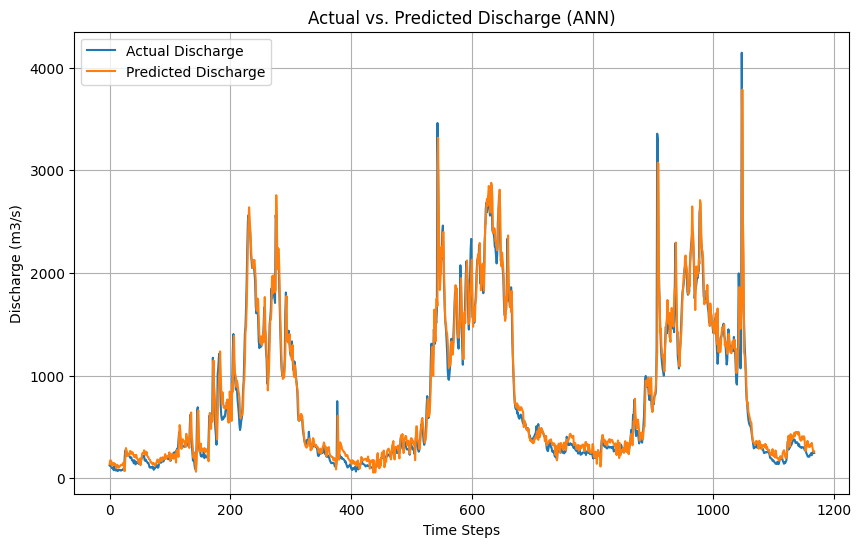

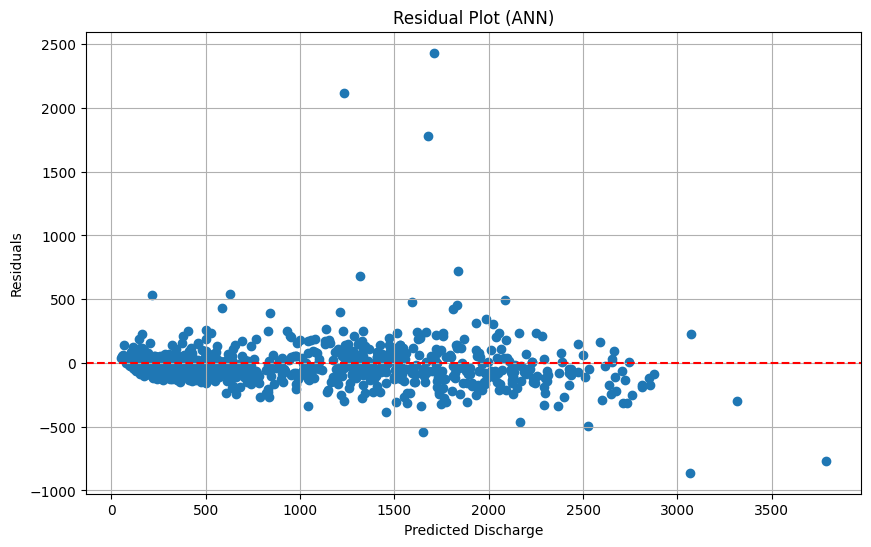

In [ ]:
# prompt: create a grapgh of predicted and actual discharge and residual plots

# Visualize actual vs. predicted values for ANN
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_ann, label='Actual Discharge')
plt.plot(y_pred_original_ann, label='Predicted Discharge')
plt.xlabel('Time Steps')
plt.ylabel('Discharge (m3/s)')
plt.title('Actual vs. Predicted Discharge (ANN)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize residuals for ANN
residuals_ann = y_test_original_ann - y_pred_original_ann
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_original_ann, residuals_ann)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Discharge')
plt.ylabel('Residuals')
plt.title('Residual Plot (ANN)')
plt.grid(True)
plt.show()

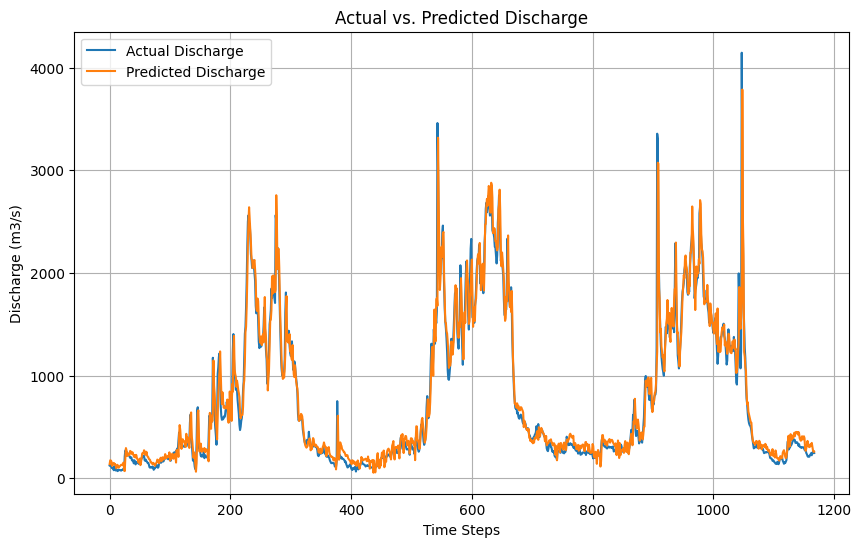

In [ ]:
# prompt: graph of predicted and actual values

# Assuming the code you provided is already executed and the variables y_test_original and y_pred_original are defined.

import matplotlib.pyplot as plt

# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original_ann, label='Actual Discharge')
plt.plot(y_pred_original_ann, label='Predicted Discharge')
plt.xlabel('Time Steps')
plt.ylabel('Discharge (m3/s)')
plt.title('Actual vs. Predicted Discharge')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# prompt: the highest value in actual and predicted value by model on that value

# Find the index of the highest actual value in the test set
index_of_highest_actual = np.argmax(y_test_original)

# Get the highest actual value
highest_actual = y_test_original[index_of_highest_actual]

# Get the predicted value corresponding to the highest actual value
predicted_for_highest_actual = y_pred_original[index_of_highest_actual]

# Print the results
print(f"Highest actual discharge in the test set: {highest_actual[0]}")
print(f"Predicted discharge for the highest actual value: {predicted_for_highest_actual[0]}")

Highest actual discharge in the test set: 4145.0
Predicted discharge for the highest actual value: 1412.3517340250528


**COMPARING THE PERFORMANCE OF ML models**

NameError: name 'y_pred_original_xgb' is not defined

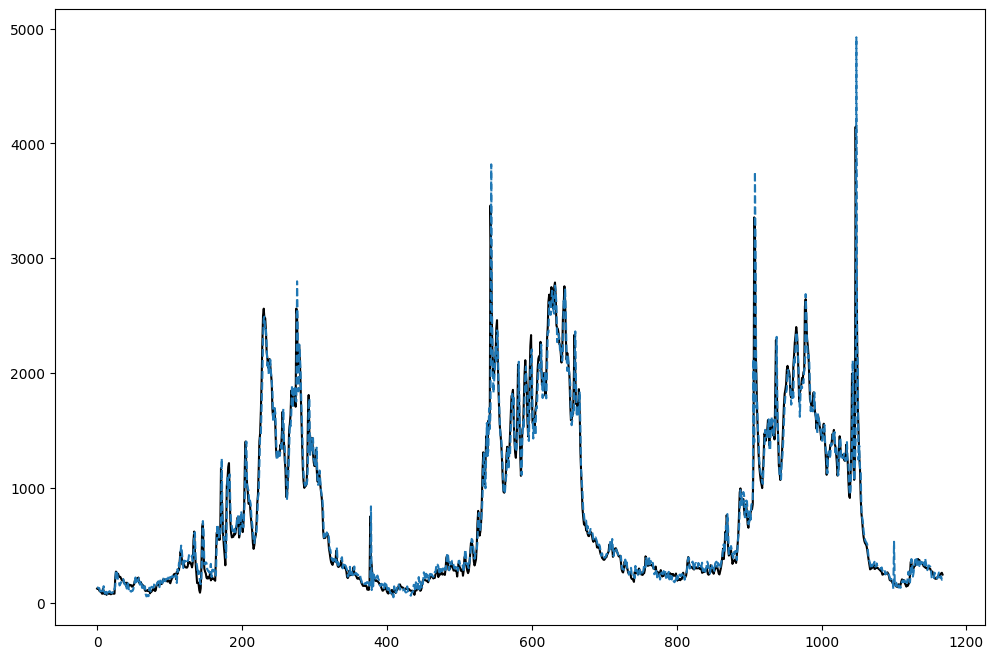

In [ ]:
# prompt: create a grapgh of all model predictions over actual values

import matplotlib.pyplot as plt

# Assuming y_test_original, y_pred_original (for SVR), y_pred_original_xgb (for XGBoost), and y_pred_original_ann (for ANN) are defined.

plt.figure(figsize=(12, 8))

# Plot actual values
plt.plot(y_test_original, label='Actual', color='black')

# Plot predicted values for each model
plt.plot(y_pred_original, label='SVR', linestyle='--')
plt.plot(y_pred_original_xgb, label='XGBoost', linestyle='-.')
plt.plot(y_pred_original_ann, label='ANN', linestyle=':')


plt.xlabel('Time Steps')
plt.ylabel('Discharge (m3/s)')
plt.title('Actual vs. Predicted Discharge (All Models)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# prompt: which model shows best results .show in tables in good colours

import pandas as pd

# Create a dictionary to store the results
model_results = {
    'Model': ['SVR', 'XGBoost', 'ANN'],
    'MSE': [mse_original, mse_original_xgb, mse_original_ann],
    'RMSE': [rmse_original, rmse_original_xgb, rmse_original_ann],
    'MAE': [mae_original, mae_original_xgb, mae_original_ann],
    'R-squared': [r2_original, r2_original_xgb, r2_original_ann],
    'NSE': [natche_original, natche_original_xgb, natche_original_ann]
}

# Create a pandas DataFrame from the results
results_df = pd.DataFrame(model_results)

# Display the table with styling
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]


styled_results = results_df.style.apply(highlight_max, subset=['R-squared', 'NSE'])

styled_results

,Model,MSE,RMSE,MAE,R-squared,NSE
0,SVR,26939.255653,164.131824,71.322166,0.948371,0.948371
1,XGBoost,33875.864622,184.053972,79.186817,0.935077,0.935077
2,ANN,25781.656178,160.566672,87.283108,0.950589,0.950589


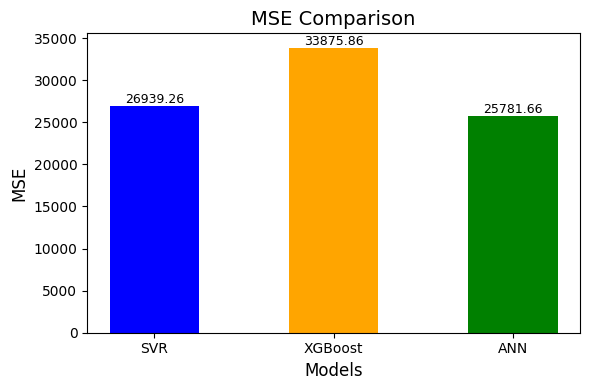

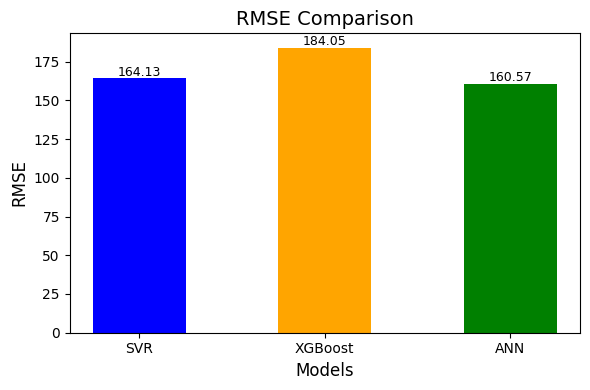

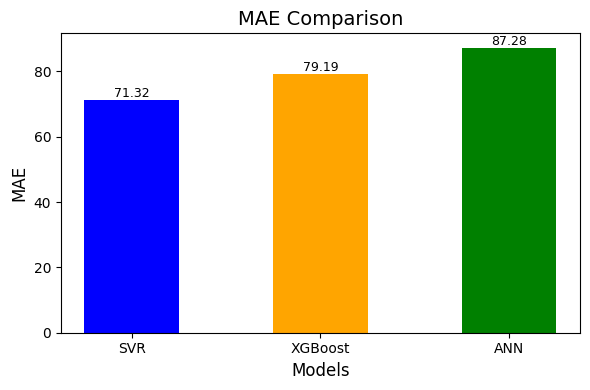

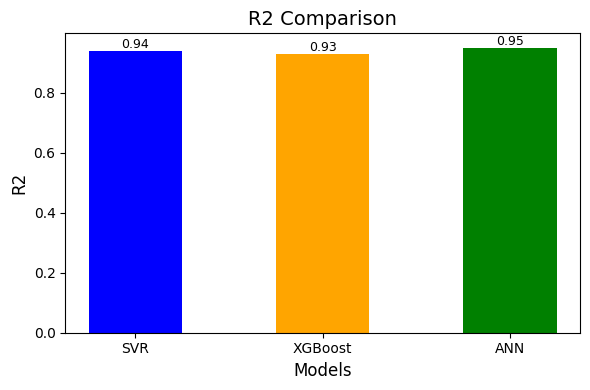

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data
models = ['SVR', 'XGBoost', 'ANN']
metrics = ['MSE', 'RMSE', 'MAE', 'R2']
data = [
    [26939.255653, 164.131824, 71.322166, 0.94],
    [33875.864622, 184.053972, 79.186817, 0.93],
    [25781.656178, 160.566672, 87.283108, 0.95]
]

# Convert data to a DataFrame
df = pd.DataFrame(data, columns=metrics, index=models)

# Plot each metric in separate charts
model_colors = ['blue', 'orange', 'green']

for metric in metrics:
    fig, ax = plt.subplots(figsize=(6, 4))
    values = df[metric]

    # Plot bars for each model
    ax.bar(models, values, color=model_colors, width=0.5)

    # Add values on top of bars
    for i, value in enumerate(values):
        ax.text(i, value + 0.01 * max(values), f'{value:.2f}', ha='center', fontsize=9)

    # Customize the plot
    ax.set_title(f'{metric} Comparison', fontsize=14)
    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    plt.tight_layout()
    plt.show()


     Model           MSE        RMSE        MAE  R-squared
0      SVR  26939.255653  164.131824  71.322166   0.948371
1  XGBoost  33875.864622  184.053972  79.186817   0.935077
2      ANN  25781.656178  160.566672  87.283108   0.950589


<ipython-input-20-d5d17c786b40>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Model", y=metric, palette="viridis")
<ipython-input-20-d5d17c786b40>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Model", y=metric, palette="viridis")
<ipython-input-20-d5d17c786b40>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Model", y=metric, palette="viridis")
<ipython-input-20-d5d17c786b40>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x

ValueError: Could not interpret value `NSE` for `y`. An entry with this name does not appear in `data`.

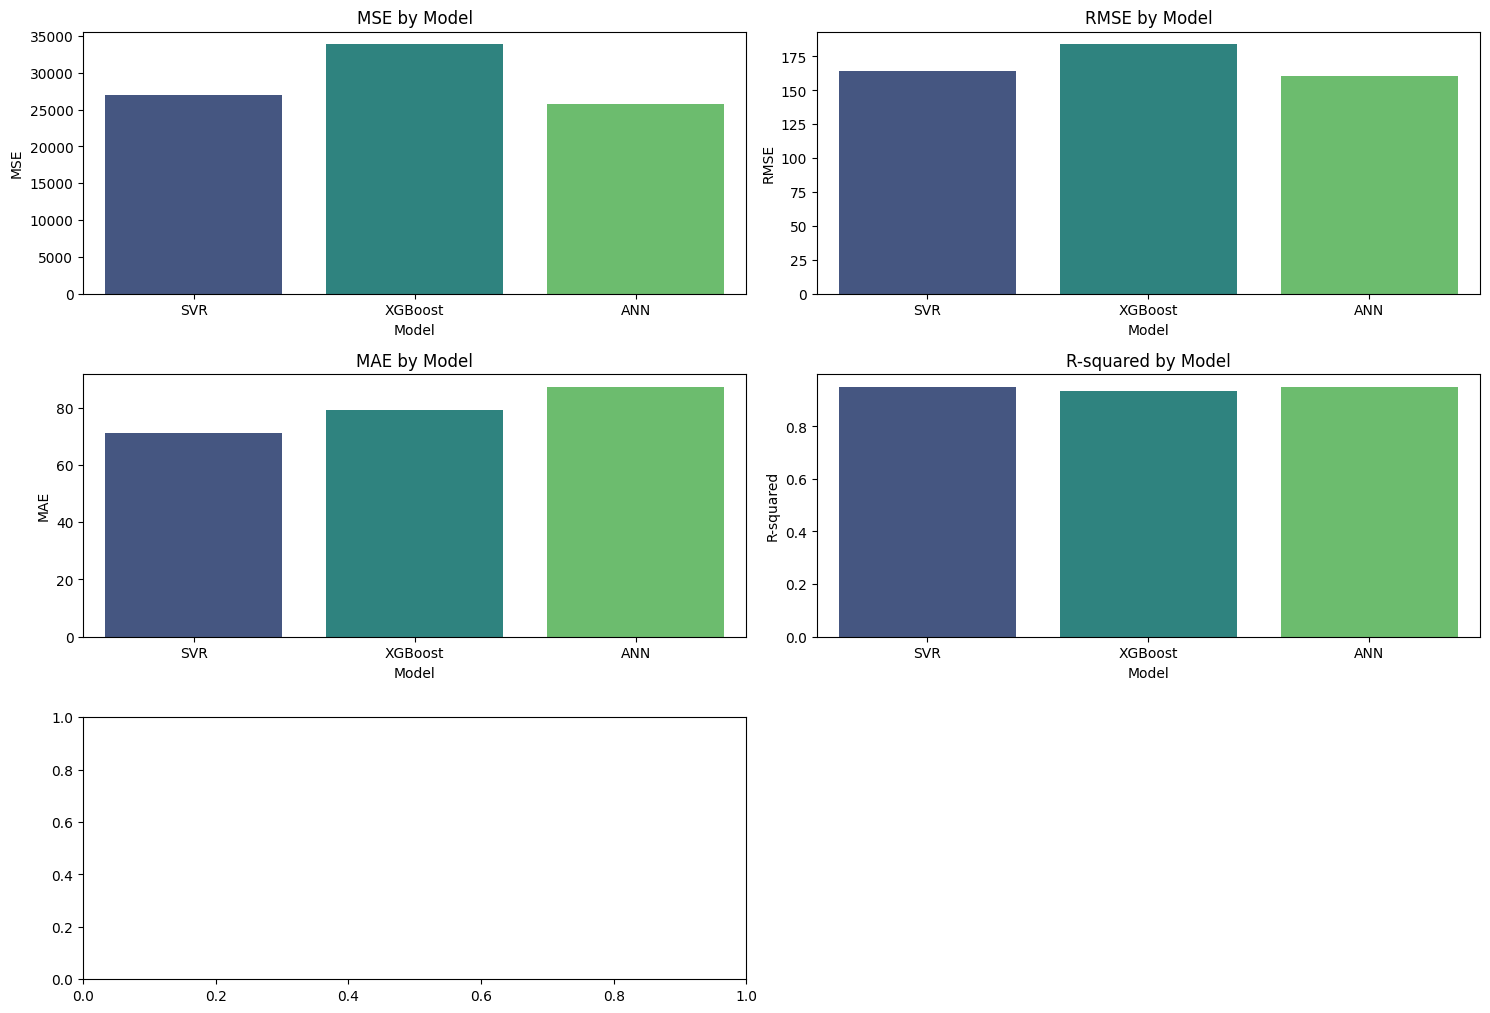

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = {
    "Model": ["SVR", "XGBoost", "ANN"],
    "MSE": [26939.255653, 33875.864622, 25781.656178],
    "RMSE": [164.131824, 184.053972, 160.566672],
    "MAE": [71.322166, 79.186817, 87.283108],
    "R-squared": [0.948371, 0.935077, 0.950589],
    "NSE": [0.948371, 0.935077, 0.950589],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

# Create bar charts for metrics
metrics = ["MSE", "RMSE", "MAE", "R-squared", "NSE"]
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.barplot(data=df, x="Model", y=metric, palette="viridis")
    plt.title(f"{metric} by Model")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.tight_layout()

# Show plots
plt.show()
